In [29]:
import re
import ast
import math
import umap
import json
import torch
import numpy as np
import pandas as pd
import plotly.io as pio
from torch.nn import Sigmoid
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [30]:
EMOTION_COLUMNS = [
    'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'disappointment', 'disapproval', 'disgust',
    'excitement', 'fear', 'gratitude', 'joy', 'love', 'optimism', 'pride',
    'remorse', 'sadness', 'surprise', 'neutral'
]

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("aymie-oh/roberta-emotion-classification")
model = AutoModelForSequenceClassification.from_pretrained("aymie-oh/roberta-emotion-classification", output_hidden_states=True)


model.to(device)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def predict_emotions(text, threshold=0.350):
   
    # Load model and tokenizer
    
    if isinstance(threshold, float):
        thresholds = [threshold] * len(EMOTION_COLUMNS)
    else:
        thresholds = threshold
    print(f"Using default threshold: {threshold}")

    # Tokenize input
    inputs = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=250,
        return_tensors="pt"
    ).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        # # embeddings = outputs.last_hidden_state
        # embeddings = outputs.last_hidden_state[:, 0, :]
        # print(embeddings.shape)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits)
    
    probs = probabilities.cpu().numpy()[0]
    
    # Get predicted emotions using thresholds
    predictions = {}
    predicted_emotions = []
    
    for i, emotion in enumerate(EMOTION_COLUMNS):
        prob = float(probs[i])
        predictions[emotion] = prob
        if prob >= thresholds[i]:
            predicted_emotions.append(emotion)
    
    return {
        # "embeddings": embeddings,
        "text": text,
        "probabilities": predictions,
        "predicted_emotions": predicted_emotions,
        "thresholds_used": dict(zip(EMOTION_COLUMNS, thresholds))
    }

In [ ]:
import textwrap

# User readable function generated via Claude

def print_predictions(result):
    """Print prediction results in a readable format"""
    print("\n===== Emotion Analysis =====")

    wrapped_text = textwrap.fill(result['text'], width=80)
    print(f'Text:\n{wrapped_text}')


    print("\nDetected emotions:")
    
    if not result['predicted_emotions']:
        print("  No emotions detected above threshold")
    else:
        emotions = [(e, result['probabilities'][e]) for e in result['predicted_emotions']]
        emotions.sort(key=lambda x: x[1], reverse=True)
        
        for emotion, prob in emotions:
            threshold = result['thresholds_used'][emotion]
            print(f"  - {emotion.upper()} ({prob:.4f}, threshold: {threshold:.2f})")
    
    print("\nAll emotion probabilities:")
    all_emotions = [(e, p) for e, p in result['probabilities'].items()]
    all_emotions.sort(key=lambda x: x[1], reverse=True)
    
    for emotion, prob in all_emotions:
        threshold = result['thresholds_used'][emotion]
        indicator = "✓" if prob >= threshold else " "
        print(f"  {indicator} {emotion}: {prob:.4f} (threshold: {threshold:.2f})")
    
    print("===========================\n")


In [ ]:

def remove_links(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def extract_post_and_comments_cleaned(json_file_path):
    with open(json_file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    post_data = data.get('post', {})
    comments_data = data.get('comments', [])
    
    post_df = pd.DataFrame([post_data]) if post_data else pd.DataFrame()
    comments_df = pd.DataFrame(comments_data) if comments_data else pd.DataFrame()
    
    if not post_df.empty:
        post_df = post_df.applymap(lambda x: remove_links(x) if isinstance(x, str) else x)
    if not comments_df.empty:
        comments_df = comments_df.applymap(lambda x: remove_links(x) if isinstance(x, str) else x)
    
    return post_df, comments_df

# Usage
json_file_path = "../reddit_json/reddit_data7.json"
post_df, comments_df = extract_post_and_comments_cleaned(json_file_path)

# Process and predict emotions for the first 10 comments
all_comments = comments_df['body'].tolist()
for i, comment in enumerate(all_comments):
    if i >= 5: 
        break
    stripped_comment = comment.strip()
    prediction = predict_emotions(stripped_comment)
    print_predictions(prediction)

Using default threshold: 0.35

===== Emotion Analysis =====
Text:
It looks like this post is about Politics. Various methods of filtering out
content relating to Politics can be found [here](  *I am a bot, and this action
was performed automatically. Please [contact the moderators of this
subreddit](/message/compose/?to=/r/pics) if you have any questions or concerns.*

Detected emotions:
  - CARING (0.5319, threshold: 0.35)
  - APPROVAL (0.5287, threshold: 0.35)
  - DISAPPROVAL (0.5137, threshold: 0.35)
  - SADNESS (0.4432, threshold: 0.35)
  - CONFUSION (0.4176, threshold: 0.35)
  - CURIOSITY (0.4059, threshold: 0.35)

All emotion probabilities:
  ✓ caring: 0.5319 (threshold: 0.35)
  ✓ approval: 0.5287 (threshold: 0.35)
  ✓ disapproval: 0.5137 (threshold: 0.35)
  ✓ sadness: 0.4432 (threshold: 0.35)
  ✓ confusion: 0.4176 (threshold: 0.35)
  ✓ curiosity: 0.4059 (threshold: 0.35)
    annoyance: 0.3090 (threshold: 0.35)
    neutral: 0.2332 (threshold: 0.35)
    anger: 0.2106 (threshold: 0

C:\Users\aymie\AppData\Local\Temp\ipykernel_25024\245645828.py:23: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\aymie\AppData\Local\Temp\ipykernel_25024\245645828.py:25: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



c:\Users\aymie\Documents\UK_projects\sentiment-analysis\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\aymie\Documents\UK_projects\sentiment-analysis\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



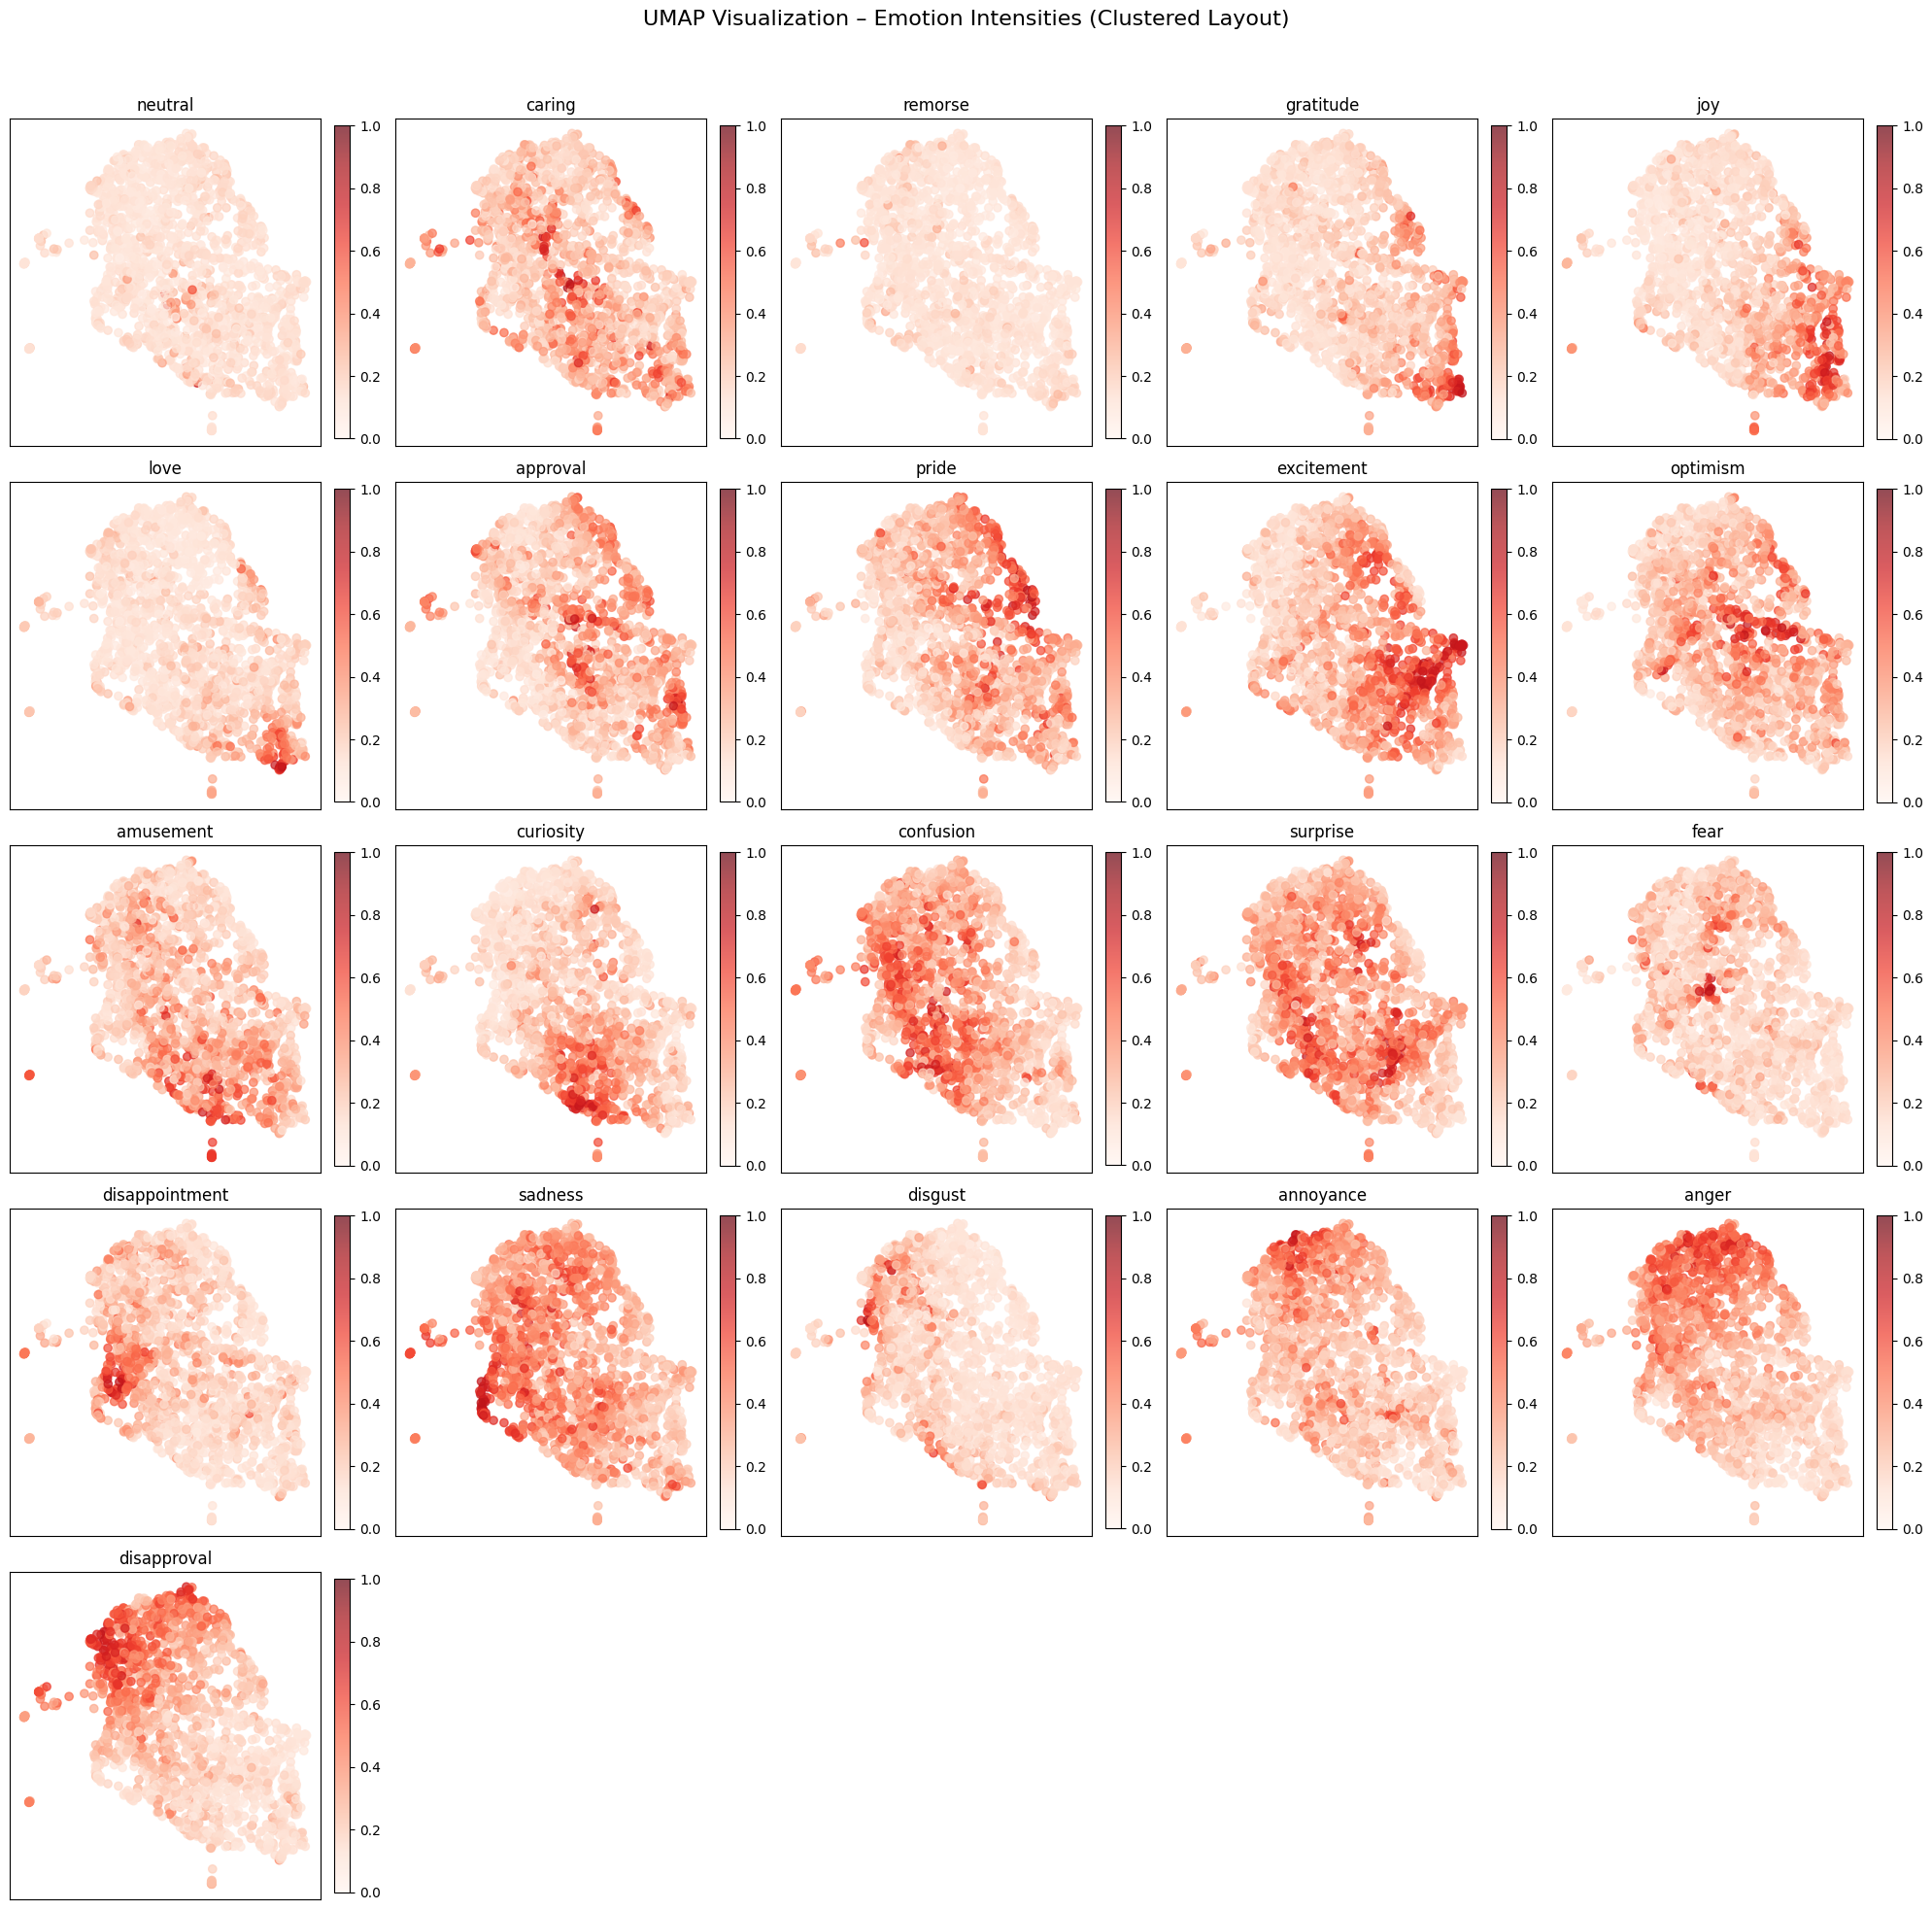

In [ ]:
comments_df = pd.read_csv('../comments_w_embeddings/comments_df_with_embeddings.csv')

# Parse the embeddings from the string format into actual lists
comments_df['embeddings'] = comments_df['embeddings'].apply(lambda x: np.array(ast.literal_eval(x)))


# Convert string to actual dictionary if it's in string format
comments_df['emotion_probs'] = comments_df['emotion_probs'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

emotion_matrix = np.stack([
    comments_df['emotion_probs'].apply(lambda d: d.get(emotion, 0)).values  
    for emotion in EMOTION_COLUMNS
])


all_embeddings = np.array([embedding.flatten() for embedding in comments_df['embeddings']])
umap_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(all_embeddings)

# # UMAP Embeddings
# all_embeddings = np.array([np.array(embedding).flatten() for embedding in comments_df['embeddings']])
# umap_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(all_embeddings)

EMOTION_COLUMNS = [
    'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'disappointment', 'disapproval', 'disgust',
    'excitement', 'fear', 'gratitude', 'joy', 'love', 'optimism', 'pride',
    'remorse', 'sadness', 'surprise', 'neutral'
]

# Cluster emotions by intensity similarity
emotion_matrix = np.stack([
    comments_df['emotion_probs'].apply(lambda d: d[emotion]).values
    for emotion in EMOTION_COLUMNS
])  # shape: (num_emotions, num_points)

distance_vector = pdist(emotion_matrix, metric='correlation')
linkage_matrix = linkage(distance_vector, method='average')

optimal_order = leaves_list(linkage_matrix)
ordered_emotions = [EMOTION_COLUMNS[i] for i in optimal_order]

n_cols = 5
n_rows = math.ceil(len(EMOTION_COLUMNS) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, emotion in enumerate(ordered_emotions):
    emotion_vals = comments_df['emotion_probs'].apply(lambda d: d[emotion]).values
    ax = axes[i]
    scatter = ax.scatter(
        umap_embeddings[:, 0], umap_embeddings[:, 1],
        c=emotion_vals, cmap='Reds', alpha=0.7, vmin=0, vmax=1
    )
    ax.set_title(emotion)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("UMAP Visualization – Emotion Intensities (Clustered Layout)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# pca = PCA(n_components=80)
# pca_embeddings = pca.fit_transform(all_embeddings)
# explained_variance = pca.explained_variance_ratio_
# print(f"PCA explained variance: {explained_variance}")
# print(f"Total PCA variance explained: {sum(explained_variance) * 100:.2f}%")


def wrap_text(text, width=50):
    return '<br>'.join([text[i:i+width] for i in range(0, len(text), width)])


# Prepare UMAP embeddings
all_embeddings = np.array([np.array(embedding).flatten() for embedding in comments_df['embeddings']])
umap_embeddings = umap.UMAP(n_components=2, random_state=42).fit_transform(all_embeddings)

# Prepare DataFrame
umap_df = pd.DataFrame(umap_embeddings, columns=['x', 'y'])

# umap_df = pd.DataFrame({
#     'x': pca_embeddings[:, 0],  # First component
#     'y': pca_embeddings[:, 1]   # Second component
# })

for emotion in EMOTION_COLUMNS:
    umap_df[emotion] = comments_df['emotion_probs'].apply(lambda d: d[emotion])

# Add comment text for hover info
# umap_df['comment'] = comments_df['body']
umap_df['comment'] = comments_df['body'].apply(lambda x: wrap_text(str(x), width=50))

# Create a separate trace for each emotion
traces = []
for i, emotion in enumerate(EMOTION_COLUMNS):
    trace = go.Scatter(
        x=umap_df['x'],
        y=umap_df['y'],
        mode='markers',
        visible=(i == 0),  
        text=umap_df['comment'],  
        hoverinfo='text',
        marker=dict(
            size=6,
            color=umap_df[emotion],
            colorscale='Reds',
            showscale=True,
            colorbar=dict(title=emotion),
            cmin=0,
            cmax=1
        ),
        name=emotion

    )
    traces.append(trace)

steps = []
for i, emotion in enumerate(EMOTION_COLUMNS):
    step = dict(
        method='update',
        args=[{
            'visible': [j == i for j in range(len(EMOTION_COLUMNS))],
        }, {
            'title': f"UMAP – Emotion Intensity ({emotion})"
        }],
        label=emotion
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Emotion: "},
    pad={"t": 50},
    steps=steps
)]

fig = go.Figure(data=traces)
fig.update_layout(
    sliders=sliders,
    title=f"UMAP – Emotion Intensity ({EMOTION_COLUMNS[0]})",
    xaxis_title="UMAP Dimension 1",
    yaxis_title="UMAP Dimension 2"
)

fig.show()
pio.write_html(fig, file="umap_emotion_slider.html", auto_open=True)

c:\Users\aymie\Documents\UK_projects\sentiment-analysis\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\aymie\Documents\UK_projects\sentiment-analysis\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

